In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap
import plotly.express as px

In [34]:
# Load the cleaned dataset
df = pd.read_csv('../data/clean_bixi_2023.csv', parse_dates=['start_time', 'end_time'])

In [35]:
# Set plot style
sns.set(style="whitegrid")

### Distribution of Trip Durations

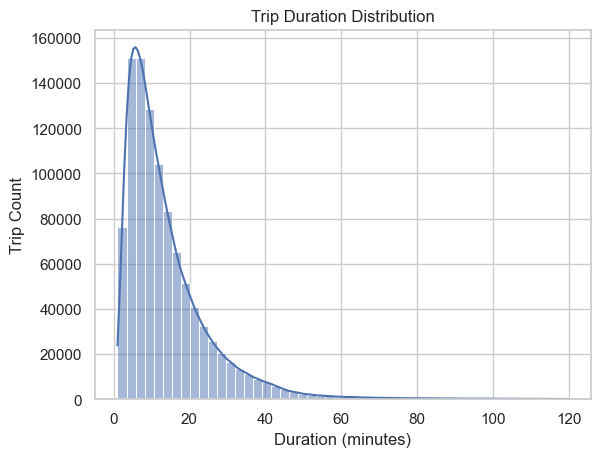

In [36]:
sns.histplot(df['trip_duration_min'], bins=50, kde=True)
plt.title('Trip Duration Distribution')
plt.xlabel('Duration (minutes)')
plt.ylabel('Trip Count')
plt.show()

### Trip Duration Statistics

In [37]:
df['trip_duration_min'].describe()

count    1.019357e+06
mean     1.390381e+01
std      1.173928e+01
min      1.000050e+00
25%      6.176267e+00
50%      1.056670e+01
75%      1.783948e+01
max      1.199753e+02
Name: trip_duration_min, dtype: float64

### Temporal Patterns

In [38]:
df['day_of_week'] = df['start_time'].dt.day_name()
df['hour_of_day'] = df['start_time'].dt.hour
df['month'] = df['start_time'].dt.month_name()

### Trips per Day of Week

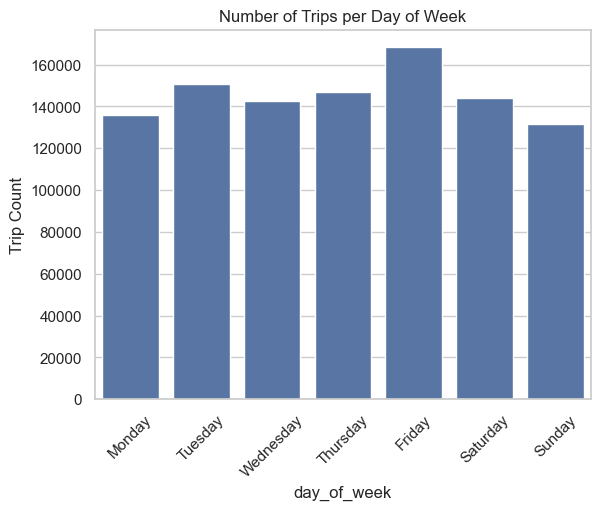

In [39]:
sns.countplot(data=df, x='day_of_week', order=[
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
])
plt.title('Number of Trips per Day of Week')
plt.ylabel('Trip Count')
plt.xticks(rotation=45)
plt.show()

### Trips per Hour of Day

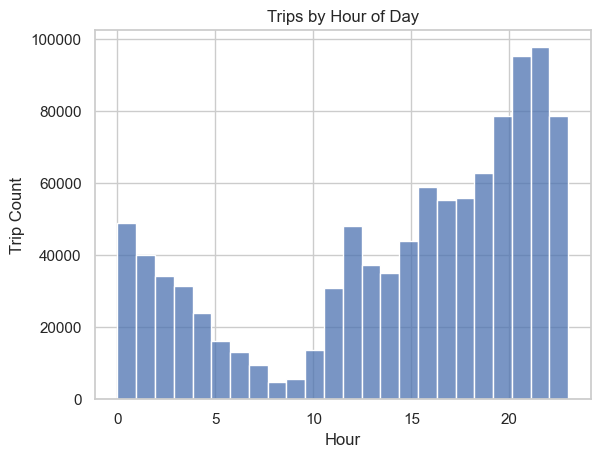

In [40]:
sns.histplot(df['hour_of_day'], bins=24)
plt.title('Trips by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Trip Count')
plt.show()

### Trips per Month

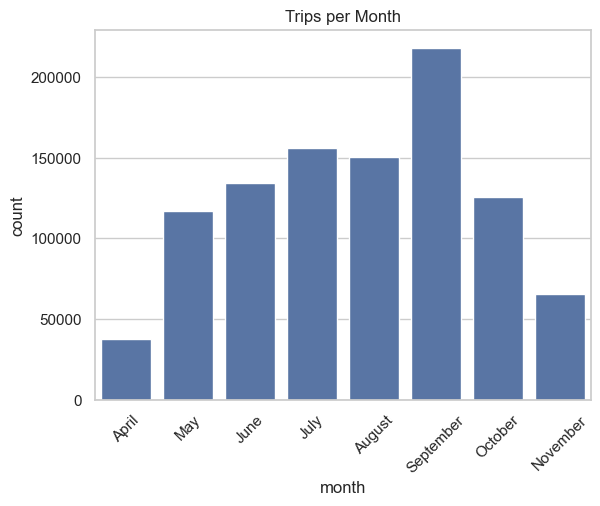

In [41]:
sns.countplot(data=df, x='month', order=[
    'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November'
])
plt.title('Trips per Month')
plt.xticks(rotation=45)
plt.show()

## Spatial Patterns

### Top 10 Start and End Stations

In [42]:
top_start = df['start_station_name'].value_counts().head(10)
top_end = df['end_station_name'].value_counts().head(10)

print("Top 10 Start Stations:\n", top_start)
print("\nTop 10 End Stations:\n", top_end)

Top 10 Start Stations:
 start_station_name
du Mont-Royal / Clark                      7012
Marquette / du Mont-Royal                  6546
des Pins / St-Laurent                      6422
Métro Atwater (Atwater / Ste-Catherine)    5834
Boyer / du Mont-Royal                      5613
Milton / University                        5567
McTavish / Sherbrooke                      5476
Mackay / de Maisonneuve                    4857
Métro Peel (de Maisonneuve / Stanley)      4629
Prince-Arthur / du Parc                    4564
Name: count, dtype: int64

Top 10 End Stations:
 end_station_name
de la Commune / Place Jacques-Cartier      6729
Marquette / du Mont-Royal                  6399
des Pins / St-Laurent                      5933
du Mont-Royal / Clark                      5822
Boyer / du Mont-Royal                      5239
Métro Atwater (Atwater / Ste-Catherine)    5187
McTavish / Sherbrooke                      5076
Peel / Ottawa                              5039
Milton / University        

### Start Station Heatmap

In [43]:
# Create coordinate list for heatmap
heat_data = df[['start_lat', 'start_lon']].dropna().values.tolist()

In [44]:
# Initialize map
m = folium.Map(location=[45.5, -73.57], zoom_start=12)

In [45]:
# Add heatmap
HeatMap(heat_data, radius=8).add_to(m)

In [46]:
# Save and display
m.save('../imgs/start_station_heatmap.html')

## Trip Flow Analysis

### Top Origin-Destination Pairs

In [47]:
od_pairs = df.groupby(['start_station_name', 'end_station_name']).size().reset_index(name='trip_count')

In [48]:
od_pairs.sort_values('trip_count', ascending=False).head(10)

,start_station_name,end_station_name,trip_count
123294,Parc Jean-Drapeau (Chemin Macdonald),Parc Jean-Drapeau (Chemin Macdonald),922
202352,de la Commune / Place Jacques-Cartier,de la Commune / Place Jacques-Cartier,374
109926,Métro Pie-IX (Pierre-de-Coubertin / Desjardins),Desjardins / Ontario,334
41539,Desjardins / Ontario,Métro Pie-IX (Pierre-de-Coubertin / Desjardins),324
8175,Argyle / de Verdun,Métro Verdun (Willibrord / de Verdun),308
36579,Clark / Prince-Arthur,Milton / University,284
109981,Métro Pie-IX (Pierre-de-Coubertin / Desjardins),Marché Maisonneuve,281
95406,Milton / University,Prince-Arthur / du Parc,279
95194,Milton / University,Clark / Prince-Arthur,270
114892,Métro Verdun (Willibrord / de Verdun),Argyle / de Verdun,261


In [49]:
# Sample: top OD pairs
od_pairs_top10 = od_pairs.sort_values('trip_count', ascending=False).head(10)

In [50]:
# Merge to get start station coordinates
od_merged = od_pairs_top10.merge(
    df[['start_station_name', 'start_lat', 'start_lon']].drop_duplicates(),
    on='start_station_name',
    how='left'
)

In [51]:
# Merge to get end station coordinates
od_merged = od_merged.merge(
    df[['end_station_name', 'end_lat', 'end_lon']].drop_duplicates(),
    on='end_station_name',
    how='left'
)

In [52]:
import folium

# Create a base map centered around Montreal
m = folium.Map(location=[45.50, -73.57], zoom_start=12)

# Add OD flow lines
for _, row in od_merged.iterrows():
    folium.PolyLine(
        locations=[
            (row['start_lat'], row['start_lon']),
            (row['end_lat'], row['end_lon'])
        ],
        tooltip=f"{row['start_station_name']} → {row['end_station_name']} ({row['trip_count']} trips)",
        color='blue',
        weight=max(row['trip_count'] / 50, 2),  # Adjust thickness
        opacity=0.6
    ).add_to(m)

# Display the map
m

In [53]:
from folium.plugins import HeatMap

# Combine start and end points for heatmap
heat_data = (
    od_merged[['start_lat', 'start_lon', 'trip_count']]
    .rename(columns={'start_lat': 'lat', 'start_lon': 'lon'})
    .to_numpy().tolist()
    +
    od_merged[['end_lat', 'end_lon', 'trip_count']]
    .rename(columns={'end_lat': 'lat', 'end_lon': 'lon'})
    .to_numpy().tolist()
)

HeatMap(heat_data, radius=15, blur=10).add_to(m)


In [54]:
# Save and display
m.save('../imgs/Top Origin-Destination Pairs.html')